In [5]:
from astropy.io import fits
from astropy.table import Table

#gen a file path list with all .fits files in a directory
import os
profiles_dir = 'output/data_radial_profiles/'
fits_files = [os.path.join(profiles_dir, f) for f in os.listdir(profiles_dir) if f.endswith('.fits')]
rows = []

for file_path in fits_files:
    with fits.open(file_path) as hdul:
        obj_row = Table(hdul[1].data)
        #if obj_row['has_profile'] == 1:
        rows.append(obj_row[0])

#gen master table
master_table = Table(rows=rows)

master_table

ID,RA_1,DEC_1,nlines,z_50,z_02,z_16,z_84,z_97,z_MAP,z_RISK,ArIII-7138_FLUX,ArIII-7138_FLUX_ERR,ArIII-7138_EW_RF_16,ArIII-7138_EW_RF_50,ArIII-7138_EW_RF_84,CIII-1908_FLUX,CIII-1908_FLUX_ERR,CIII-1908_EW_RF_16,CIII-1908_EW_RF_50,CIII-1908_EW_RF_84,CIV-1549_FLUX,CIV-1549_FLUX_ERR,CIV-1549_EW_RF_16,CIV-1549_EW_RF_50,CIV-1549_EW_RF_84,H8_FLUX,H8_FLUX_ERR,H8_EW_RF_16,H8_EW_RF_50,H8_EW_RF_84,H9_FLUX,H9_FLUX_ERR,H9_EW_RF_16,H9_EW_RF_50,H9_EW_RF_84,Ha_FLUX,Ha_FLUX_ERR,Ha_EW_RF_16,Ha_EW_RF_50,Ha_EW_RF_84,Hb_FLUX,Hb_FLUX_ERR,Hb_EW_RF_16,Hb_EW_RF_50,Hb_EW_RF_84,Hd_FLUX,Hd_FLUX_ERR,Hd_EW_RF_16,Hd_EW_RF_50,Hd_EW_RF_84,HeI-1083_FLUX,HeI-1083_FLUX_ERR,HeI-1083_EW_RF_16,HeI-1083_EW_RF_50,HeI-1083_EW_RF_84,HeI-5877_FLUX,HeI-5877_FLUX_ERR,HeI-5877_EW_RF_16,HeI-5877_EW_RF_50,HeI-5877_EW_RF_84,HeII-1640_FLUX,HeII-1640_FLUX_ERR,HeII-1640_EW_RF_16,HeII-1640_EW_RF_50,HeII-1640_EW_RF_84,Hg_FLUX,Hg_FLUX_ERR,Hg_EW_RF_16,Hg_EW_RF_50,Hg_EW_RF_84,Lya_FLUX,Lya_FLUX_ERR,Lya_EW_RF_16,Lya_EW_RF_50,Lya_EW_RF_84,MgII_FLUX,MgII_FLUX_ERR,MgII_EW_RF_16,MgII_EW_RF_50,MgII_EW_RF_84,NIII-1750_FLUX,NIII-1750_FLUX_ERR,NIII-1750_EW_RF_16,NIII-1750_EW_RF_50,NIII-1750_EW_RF_84,NIV-1487_FLUX,NIV-1487_FLUX_ERR,NIV-1487_EW_RF_16,NIV-1487_EW_RF_50,NIV-1487_EW_RF_84,NV-1240_FLUX,NV-1240_FLUX_ERR,NV-1240_EW_RF_16,NV-1240_EW_RF_50,NV-1240_EW_RF_84,NeIII-3867_FLUX,NeIII-3867_FLUX_ERR,NeIII-3867_EW_RF_16,NeIII-3867_EW_RF_50,NeIII-3867_EW_RF_84,NeV-3346_FLUX,NeV-3346_FLUX_ERR,NeV-3346_EW_RF_16,NeV-3346_EW_RF_50,NeV-3346_EW_RF_84,NeVI-3426_FLUX,NeVI-3426_FLUX_ERR,NeVI-3426_EW_RF_16,NeVI-3426_EW_RF_50,NeVI-3426_EW_RF_84,OI-6302_FLUX,OI-6302_FLUX_ERR,OI-6302_EW_RF_16,OI-6302_EW_RF_50,OI-6302_EW_RF_84,OII_FLUX,OII_FLUX_ERR,OII_EW_RF_16,OII_EW_RF_50,OII_EW_RF_84,OII-7325_FLUX,OII-7325_FLUX_ERR,OII-7325_EW_RF_16,OII-7325_EW_RF_50,OII-7325_EW_RF_84,OIII_FLUX,OIII_FLUX_ERR,OIII_EW_RF_16,OIII_EW_RF_50,OIII_EW_RF_84,OIII-1663_FLUX,OIII-1663_FLUX_ERR,OIII-1663_EW_RF_16,OIII-1663_EW_RF_50,OIII-1663_EW_RF_84,OIII-4363_FLUX,OIII-4363_FLUX_ERR,OIII-4363_EW_RF_16,OIII-4363_EW_RF_50,OIII-4363_EW_RF_84,PaB_FLUX,PaB_FLUX_ERR,PaB_EW_RF_16,PaB_EW_RF_50,PaB_EW_RF_84,SII_FLUX,SII_FLUX_ERR,SII_EW_RF_16,SII_EW_RF_50,SII_EW_RF_84,SIII_FLUX,SIII_FLUX_ERR,SIII_EW_RF_16,SIII_EW_RF_50,SIII_EW_RF_84,HeII-4687_FLUX,HeII-4687_FLUX_ERR,HeII-4687_EW_RF_16,HeII-4687_EW_RF_50,HeII-4687_EW_RF_84,T_G102,T_G141,BIC_TEMP,CHIMIN,DOF,subfield,id,ra,dec,z_spec,nusefilt,lc_min,lc_max,z_phot,z_phot_chi2,z_phot_risk,z_min_risk,min_risk,z_raw_chi2,raw_chi2,z025,z160,z500,z840,z975,restU,restU_err,restB,restB_err,restV,restV_err,restJ,restJ_err,dL,mass,sfr,Lv,LIR,MLv,Av,mass_p,sfr_p,Lv_p,LIR_p,ssfr_p,rest270,rest270_err,rest274,rest274_err,rest120,rest120_err,rest121,rest121_err,rest156,rest156_err,rest157,rest157_err,rest158,rest158_err,rest159,rest159_err,rest160,rest160_err,rest161,rest161_err,rest162,rest162_err,rest163,rest163_err,DISTMOD,ABSM_271,ABSM_272,ABSM_274,NUMBER,RA_2,DEC_2,f,mag,dmag,re,dre,n,dn,q,dq,pa,dpa,sn,field,sn_ha,sn_hb,pixel_length,tag,distance,ha,ha_err,ha_limit,hb,hb_err,hb_limit,balmer,balmer_err,E_bv,A_ha,has_profile
int32,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,flo

# Test of diagnostic plots

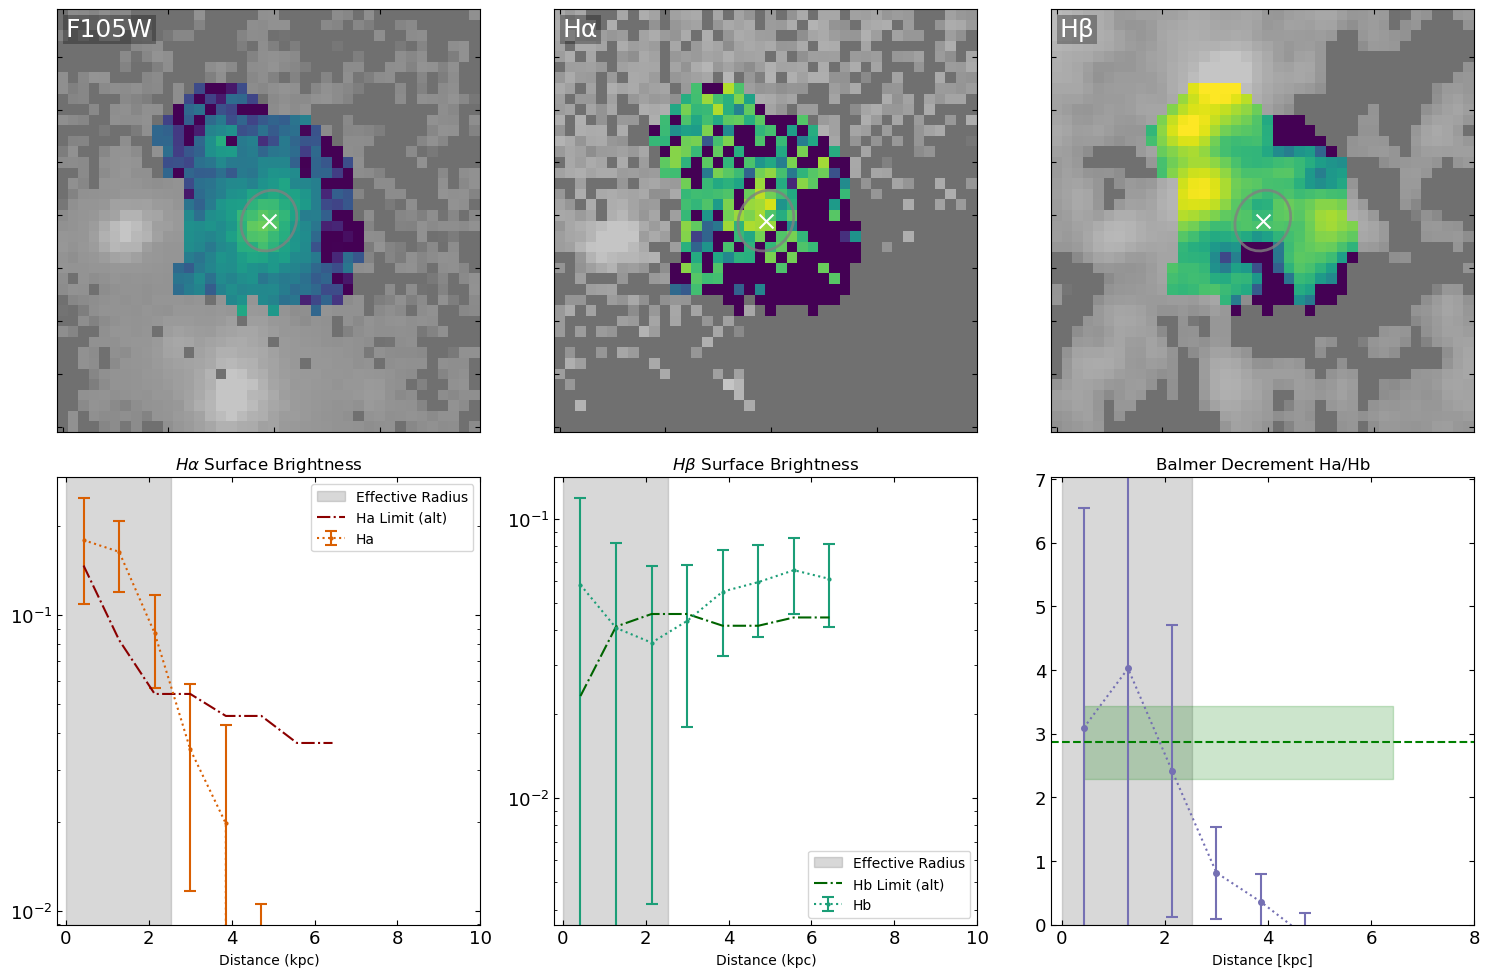

In [23]:
from astropy.visualization import ImageNormalize, PercentileInterval, AsinhStretch
import astropy.units as u
from matplotlib import cm
import numpy as np
from photutils.aperture import EllipticalAperture
from astropy.visualization import LogStretch, ImageNormalize
from utils.colors import color1, color2, color3
%matplotlib inline
from matplotlib import pyplot as plt

def plot_for_obj(extracted_fits_path, profile_fits_path):
    with fits.open(profile_fits_path) as hdul:
        obj = Table(hdul[1].data)[0]
        r=obj['distance']/0.1 * obj['pixel_length']
        ha=obj['ha']; ha_err=obj['ha_err']; ha_lim=obj['ha_limit']
        hb=obj['hb']; hb_err=obj['hb_err']; hb_lim=obj['hb_limit']
        balmer = obj['balmer']; balmer_err = obj['balmer_err']
        
    with fits.open(extracted_fits_path) as hdul:
        
        re = obj['re']/0.1; q = obj['q']; pa = obj['pa']
        
        #prepare segmentation map
        seg = hdul[2].data == obj['ID']
        #prepare 2D Balmer map
        
        plt.figure(figsize=(15,10))        
        for plot_index, hdul_index, name in [
                (1, 3, f"{hdul[3].header['FILTER']}"),
                (2, 4, 'Hα'),
                (3, 6, 'Hβ')]:
            ax = plt.subplot(2, 3, plot_index)
            ax.tick_params(axis='both', labelbottom=False, direction='in', which='both', 
            top=True, right=True, left=True, bottom=True, labelsize=13)
            
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            
            ax.text(
                0.02, 0.98, f"{name}", transform=ax.transAxes,
                fontsize=18, color='white', va='top', ha='left',
                bbox=dict(facecolor='black', alpha=0.3, edgecolor='none', pad=2)
            )
            data = hdul[hdul_index].data
            # avoid zeros and negatives for log stretch
            norm = ImageNormalize(np.where(data > 0, data, np.nan), interval=PercentileInterval(99.5), stretch=LogStretch())

            # plot the segmentation map
            viridis_cmap = plt.get_cmap('viridis')
            grey_viridis_cmap = cm.colors.ListedColormap(
                np.mean(viridis_cmap(np.linspace(0, 1, 256))[:, :3], axis=1, keepdims=True).repeat(3, axis=1))
            grey_viridis_cmap._init()

            ax.imshow(np.where(seg, data, np.nan), origin='lower', norm=norm, cmap='viridis')
            ax.imshow(np.where(~seg, data, np.nan), origin='lower', norm=norm, cmap=grey_viridis_cmap, alpha=0.7)
            # set the title


            # plot the ellipse at the effective radius for all images, use photutils aperture
            center = (data.shape[1]/2-0.5, data.shape[0]/2-0.5)
            aperture = EllipticalAperture(center, a=re, b=re * q, theta=np.deg2rad(pa*u.deg - 90*u.deg))
            aperture.plot(ax=ax, color='gray', lw=2, alpha=0.8, label='Effective Radius')
            ax.scatter(center[1], center[0], color='white', s=100, marker='x', label='Center')

            # Set the axis limits to center a 30x30 region around the image center
            y, x = center
            ax.set_xlim(x - 20, x + 20)
            ax.set_ylim(y - 20, y + 20)
            
#--------------plot radial profiles-----------------
        ax = plt.subplot(2, 3, 4)
        ax.tick_params(axis='both', labelbottom=True, direction='in', which='both', 
                top=True, right=True, left=True, bottom=True, labelsize=13)
        #plot a grey area representing the effective radius
        ax.axvspan(0, re*obj['pixel_length'], color='grey', alpha=0.3, label='Effective Radius')
        ax.errorbar(r, ha, yerr=ha_err, label='Ha', fmt='o:', color=color2, markersize=2,
            capsize=4, capthick=1.5, elinewidth=1.5)
        #plot halimit as horizontal line
        ax.plot(r, ha_lim, color='darkred', linestyle='-.', label='Ha Limit (alt)')

        ax.set_xlim(-0.2, 10)
        ax.set_xlabel('Distance (kpc)')
        ax.set_title('$H\\alpha$ Surface Brightness')
        ax.set_yscale('log')
        ax.legend()

        #plot the radial profile of ha and hb s/n
        ax = plt.subplot(2, 3, 5)
        ax.tick_params(axis='both', labelbottom=True, direction='in', which='both', 
                top=True, right=True, left=True, bottom=True, labelsize=13)
        #plot a grey area representing the effective radius
        ax.axvspan(0, re*obj['pixel_length'], color='grey', alpha=0.3, label='Effective Radius')
        ax.errorbar(r, hb, yerr=hb_err, label='Hb', fmt='o:', color=color1, markersize=2,
            capsize=4, capthick=1.5, elinewidth=1.5)
        #plot hblimit as horizontal line
        ax.plot(r, hb_lim, color='darkgreen', linestyle='-.', label='Hb Limit (alt)')
                                        
        ax.set_xlim(-0.2, 10)
        ax.set_xlabel('Distance (kpc)')
        ax.set_title('$H\\beta$ Surface Brightness')
        ax.set_yscale('log')
        ax.legend()

        #plot the radial profile of balmer decrement
        ax = plt.subplot(2, 3, 6)
        ax.tick_params(axis='both', labelbottom=True, direction='in', which='both', 
                top=True, right=True, left=True, bottom=True, labelsize=13)
        ax.axvspan(0, re*obj['pixel_length'], color='grey', alpha=0.3, label='Effective Radius')
        ax.errorbar(
            r, balmer, yerr=balmer_err, label='Balmer Decrement',
            fmt='o:', color=color3, markersize=4,
            capsize=4, capthick=1.5, elinewidth=1.5
        )
        ax.axhline(y=2.86, color='green', linestyle='--', label='theory')
        ax.fill_between(r, 2.86*0.8, 2.86*1.2, color='green', alpha=0.2)
        ax.set_xlim(-0.2, 8)
        ax.set_ylim(0, np.nanmin([np.nanmax(balmer)+3,25]))
        ax.set_xlabel('Distance [kpc]')
        ax.set_title('Balmer Decrement Ha/Hb')
        plt.tight_layout()
        plt.show()

profile_fits_path = '/Users/yangcheng/clear_bd/Balmer-Decrement-CLEAR/output/data_radial_profiles/gn2_10653_profile.fits'

extracted_fits_path = '/Users/yangcheng/clear_bd/Balmer-Decrement-CLEAR/output/data_extracted/gn2_10653_extracted.fits'

plot_for_obj(extracted_fits_path, profile_fits_path)